In [82]:
from sklearn.datasets import fetch_20newsgroups
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from nltk.stem.snowball import SnowballStemmer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.utils import to_categorical

In [83]:
import os
from nltk.tokenize import sent_tokenize

nltk.download('punkt', quiet=True)

def get_first_sentence_and_rest(text, short_threshold=200):
    if not text:
        return "", ""

    t = text.lstrip()
    lines = t.splitlines()

    # find first non-empty line
    first_nonempty = None
    first_idx = 0
    for i, line in enumerate(lines):
        if line.strip():
            first_nonempty = line
            first_idx = i
            break

    if first_nonempty is None:
        return "", t

    ends_with_punct = bool(re.search(r'[.?!…]["\')\]]*\s*$', first_nonempty.strip()))

    if len(first_nonempty) <= short_threshold and not ends_with_punct:
        headline = first_nonempty.strip()
        rest_lines = lines[first_idx+1:]
        rest = '\n'.join(rest_lines).lstrip()
        if not rest.strip():
            sentences = sent_tokenize(t)
            if sentences:
                first = sentences[0].strip()
                pos = t.find(first)
                rest = t[pos + len(first):].lstrip()
                return first, rest
            else:
                return headline, ""
        return headline, rest
    else:
        sentences = sent_tokenize(t)
        if sentences:
            first = sentences[0].strip()
            pos = t.find(first)
            rest = t[pos + len(first):].lstrip()
            return first, rest
        else:
            return "", t

root_dir = "/kaggle/input/bbc-full-text-document-classification/bbc" 

data = []
for category in sorted(os.listdir(root_dir)):
    category_path = os.path.join(root_dir, category)
    if not os.path.isdir(category_path):
        continue
    for filename in sorted(os.listdir(category_path)):
        if not filename.lower().endswith('.txt'):
            continue
        file_path = os.path.join(category_path, filename)
        with open(file_path, 'r', encoding='utf-8', errors='replace') as f:
            text = f.read()
        headline, rest_text = get_first_sentence_and_rest(text)
        data.append({
            "category": category,
            "filename": filename,
            "headline": headline,
            "rest_text": rest_text,
            "full_text": text
        })

df = pd.DataFrame(data)
df.to_csv("headline_and_rest.csv", index=False)
print(df[['category','filename','headline' , "rest_text"]].head())

   category filename                           headline  \
0  business  001.txt  Ad sales boost Time Warner profit   
1  business  002.txt   Dollar gains on Greenspan speech   
2  business  003.txt  Yukos unit buyer faces loan claim   
3  business  004.txt  High fuel prices hit BA's profits   
4  business  005.txt  Pernod takeover talk lifts Domecq   

                                           rest_text  
0  Quarterly profits at US media giant TimeWarner...  
1  The dollar has hit its highest level against t...  
2  The owners of embattled Russian oil giant Yuko...  
3  British Airways has blamed high fuel prices fo...  
4  Shares in UK drinks and food firm Allied Domec...  


In [84]:
def clean(df, col):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    RE_TAGS = re.compile(r"<[^>]+>")
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)

    cleaned_sentences = []

    for sentence in df[col]:
        sentence = re.sub(r'[^a-zA-Z\s]', '', sentence)
        sentence = word_tokenize(sentence)
        sentence = [word.lower() for word in sentence]
        sentence = [word for word in sentence if word not in stop_words]

        cleaned_tokens = []
        for token in sentence:
            token = re.sub(RE_TAGS, " ", token)
            token = re.sub(RE_ASCII, " ", token)
            token = re.sub(RE_SINGLECHAR, " ", token)
            token = re.sub(RE_WSPACE, " ", token)
            token = token.strip()
            if token:  
                cleaned_tokens.append(token)

        cleaned_tokens = [lemmatizer.lemmatize(word) for word in cleaned_tokens]
        cleaned_sentences.append(cleaned_tokens)

    return pd.Series(cleaned_sentences)


In [85]:
df["headline"] = clean(df, "headline")
df["rest_text"] = clean(df, "rest_text")

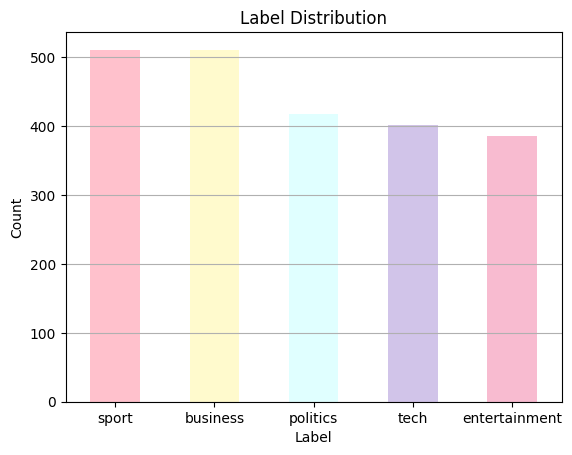

In [86]:
import matplotlib.pyplot as plt

label_counts = df['category'].value_counts()

label_counts.plot(kind='bar', color=["#FFC1CC",  
"#FFFACD",  
"#E0FFFF", 
"#D1C4E9",
"#F8BBD0"  
])
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

In [87]:
from collections import (
    defaultdict,
)  
vocab = defaultdict(int)
for tokens in df['rest_text']:
    for word in tokens:
        vocab[word] += 1
sorted_vocab = dict(sorted(vocab.items(), key=lambda x: x[1], reverse=True))
#print("Vocabulary with Frequencies:", sorted_vocab)

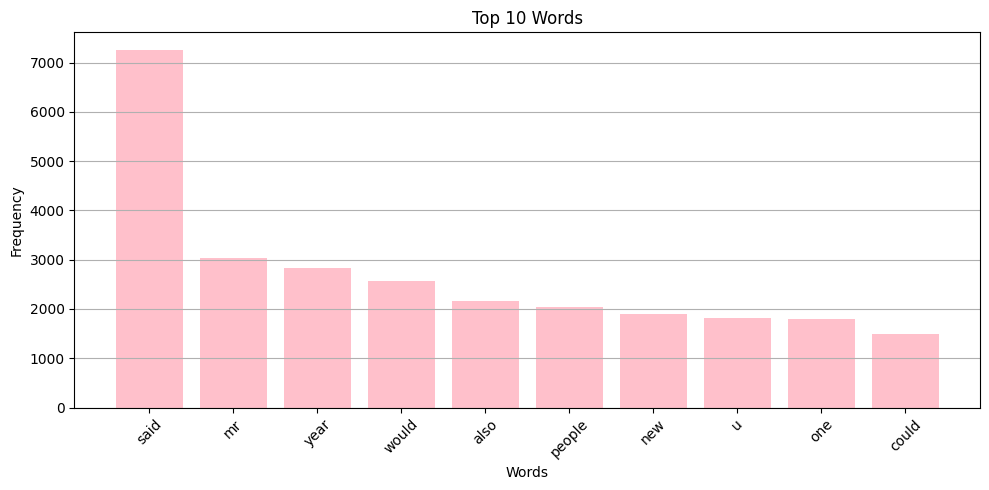

In [88]:
import matplotlib.pyplot as plt

top_n = 10
top_words = list(sorted_vocab.items())[:top_n]
words, freqs = zip(*top_words)

plt.figure(figsize=(10, 5))
plt.bar(words, freqs, color='pink')
plt.title(f"Top {top_n} Words")
plt.xticks(rotation=45)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Text-only Headline Generator (Sequence Model)

In [89]:
df['headline'] = df['headline'].apply(lambda x: "<start> " + " ".join(x) + " <end>")

In [90]:
INPUT_LEN = []
HEADLINE_LEN = []

for i in df.rest_text:
    INPUT_LEN.append(len(i)) 

for i in df.headline:
    HEADLINE_LEN.append(len(i))

In [91]:
max(INPUT_LEN), max(HEADLINE_LEN)

(2207, 157)

In [92]:
MAX_VOCAB = 15000
MAX_INPUT_LEN = 243
MAX_HEADLINE_LEN = 47 

In [93]:
#input tokenizer
input_tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token='<OOV>')
input_tokenizer.fit_on_texts(df['rest_text'])
input_seq = input_tokenizer.texts_to_sequences(df['rest_text'])
input_pad = pad_sequences(input_seq, maxlen=MAX_INPUT_LEN, padding='post')

In [94]:
#output tokenizer
output_tokenizer = Tokenizer(
    num_words=MAX_VOCAB,
    oov_token='<OOV>',
    filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'  # allows <start> and <end>
)

output_tokenizer.fit_on_texts(df['headline'])
output_seq = output_tokenizer.texts_to_sequences(df['headline'])
output_pad = pad_sequences(output_seq, maxlen=MAX_HEADLINE_LEN, padding='post')

In [95]:
print('<start>' in output_tokenizer.word_index)
print('<end>' in output_tokenizer.word_index)    

True
True


In [96]:
output_vocab_size = min(MAX_VOCAB, len(output_tokenizer.word_index) + 1)

In [97]:
decoder_input_data = output_pad[:, :-1]
decoder_target_data = output_pad[:, 1:]
decoder_input_data = pad_sequences(decoder_input_data, maxlen=MAX_HEADLINE_LEN, padding='post')
decoder_target_data = pad_sequences(decoder_target_data, maxlen=MAX_HEADLINE_LEN, padding='post')
decoder_target_data = np.expand_dims(decoder_target_data, -1)

In [98]:
print(input_pad.shape)
print(decoder_input_data.shape)
print(decoder_target_data.shape)

(2225, 243)
(2225, 47)
(2225, 47, 1)


In [99]:
X_train, X_test, y_train_input, y_test_input, y_train_target, y_test_target = train_test_split(
    input_pad, decoder_input_data, decoder_target_data, test_size=0.2, random_state=42
)

In [100]:
embedding_dim = 128
lstm_units = 128

In [101]:
encoder_input = Input(shape=(MAX_INPUT_LEN,))
encoder_emb = Embedding(MAX_VOCAB, embedding_dim)(encoder_input)
encoder_output, state_h, state_c = LSTM(lstm_units, return_state=True)(encoder_emb)

In [102]:
decoder_input = Input(shape=(MAX_HEADLINE_LEN,))
decoder_emb = Embedding(MAX_VOCAB, embedding_dim)(decoder_input)
decoder_lstm_layer = LSTM(lstm_units, return_sequences=True)
decoder_lstm = LSTM(lstm_units, return_sequences=True)(decoder_emb, initial_state=[state_h, state_c])
decoder_output = Dense(output_vocab_size, activation='softmax')(decoder_lstm)

In [103]:
model = Model([encoder_input, decoder_input], decoder_output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [104]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 243)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 47)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 243, 128)  │  1,920,000 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 47, 128)   │  1,920,000 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, 128),     │    131,584 │ embedding_2[0][0] │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 47, 128)   │    131,584 │ embedding_3[0][0… │
│                     │                   │            │ lstm_3[0][1],     │
│                     │                   │            │ lstm_3[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 47, 3300)  │    425,700 │ lstm_5[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,528,868 (17.28 MB)

 Trainable params: 4,528,868 (17.28 MB)

 Non-trainable params: 0 (0.00 B)

In [105]:
history = model.fit([X_train, y_train_input], y_train_target, epochs= 10, batch_size=128, validation_split=0.1)

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.6786 - loss: 7.4430 - val_accuracy: 0.8855 - val_loss: 4.5416
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8852 - loss: 3.5813 - val_accuracy: 0.8855 - val_loss: 1.4204
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8854 - loss: 1.2139 - val_accuracy: 0.8855 - val_loss: 0.9226
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8853 - loss: 0.8877 - val_accuracy: 0.8855 - val_loss: 0.8435
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8847 - loss: 0.8296 - val_accuracy: 0.8855 - val_loss: 0.8181
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8861 - loss: 0.7916 - val_accuracy: 0.8857 - val_loss: 0.8036
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8874 - loss: 0.7756 - val_accuracy: 0.8879 - val_loss: 0.7941
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8920 - loss: 0.7646 - val_accuracy: 0.8974 - val_loss:

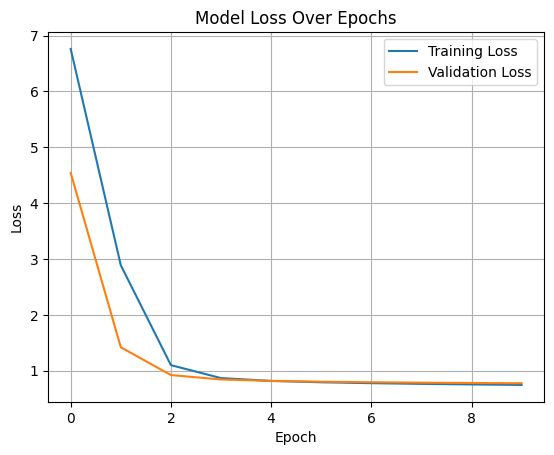

In [106]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')  
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [107]:
def clean(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s<>]", "", text)
    return text
def generate_headline(description, temperature=1.2):
    #desc = clean(description)
    desc = description
    seq = input_tokenizer.texts_to_sequences([desc])
    padded_seq = pad_sequences(seq, maxlen=MAX_INPUT_LEN, padding='post')

    start_token = output_tokenizer.word_index.get('<start>')
    end_token = output_tokenizer.word_index.get('<end>')

    if start_token is None or end_token is None:
        raise ValueError("Start or End token not found in tokenizer vocabulary.")

    decoder_input_seq = [start_token]
    predicted_tokens = []

    for _ in range(MAX_HEADLINE_LEN):
        decoder_input_pad = pad_sequences([decoder_input_seq], maxlen=MAX_HEADLINE_LEN, padding='post')
        prediction = model.predict([padded_seq, decoder_input_pad], verbose=0)

        prediction = prediction[0, len(decoder_input_seq)-1]
        prediction = np.log(prediction + 1e-7) / temperature
        prediction = np.exp(prediction) / np.sum(np.exp(prediction)) 
        next_token = np.random.choice(range(output_vocab_size), p=prediction)

        if next_token == end_token or next_token == 0:
            break

        predicted_tokens.append(next_token)
        decoder_input_seq.append(next_token)

    headline = ''
    for token in predicted_tokens:
        if token != 0:
            headline += output_tokenizer.index_word.get(token, '<UNK>') + ' '

    return headline.strip()

In [108]:
sample_description = "Health experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the U.S. ordered for the fall."
predicted_headline = generate_headline(sample_description)

print("Input Description:", sample_description)  
print("\nPredicted Headline:", predicted_headline)

Input Description: Health experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the U.S. ordered for the fall.

Predicted Headline: china digital ringtone buffet brennan spurt blogger


In [109]:
df

,category,filename,headline,rest_text,full_text
0,business,001.txt,<start> ad sale boost time warner profit <end>,"[quarterly, profit, u, medium, giant, timewarn...",Ad sales boost Time Warner profit\n\nQuarterly...
1,business,002.txt,<start> dollar gain greenspan speech <end>,"[dollar, hit, highest, level, euro, almost, th...",Dollar gains on Greenspan speech\n\nThe dollar...
2,business,003.txt,<start> yukos unit buyer face loan claim <end>,"[owner, embattled, russian, oil, giant, yukos,...",Yukos unit buyer faces loan claim\n\nThe owner...
3,business,004.txt,<start> high fuel price hit ba profit <end>,"[british, airway, blamed, high, fuel, price, d...",High fuel prices hit BA's profits\n\nBritish A...
4,business,005.txt,<start> pernod takeover talk lift domecq <end>,"[share, uk, drink, food, firm, allied, domecq,...",Pernod takeover talk lifts Domecq\n\nShares in...
...,...,...,...,...,...
2220,tech,397.txt,<start> bt program beat dialler scam <end>,"[bt, introducing, two, initiative, help, beat,...",BT program to beat dialler scams\n\nBT is intr...
2221,tech,398.txt,<start> spam email tempt net shopper <end>,"[computer, user, across, world, continue, igno...",Spam e-mails tempt net shoppers\n\nComputer us...
2222,tech,399.txt,<start> careful code <end>,"[new, european, directive, could, put, softwar...",Be careful how you code\n\nA new European dire...
2223,tech,400.txt,<start> u cyber security chief resigns <end>,"[man, making, sure, u, computer, network, safe...",US cyber security chief resigns\n\nThe man mak...


In [110]:
#resplitting to get string documents again to generate and get the bleu score
X_train, X_test, y_train , y_test = train_test_split(
    df["rest_text"] , df["headline"], test_size=0.2, random_state=42
)

In [113]:
# caption -> headline
new_generated = []
i = 0
for i in range(len(X_test)):
    headline = generate_headline(X_test.iloc[i])
    generated.append(headline)
    if i % 50 == 0:
        print("Reached caption:" , i , headline)

Reached caption: 0 top texting prevails wmc ericsson trade terror
Reached caption: 50 story debut gear
Reached caption: 100 saudi bellamy boogeyman anil browser dual belle iran
Reached caption: 150 trim break peru prevails pocket maruti
Reached caption: 200 triple
Reached caption: 250 rate rue bennett homophobic favour takeover mantle divert
Reached caption: 300 management charity island gift dominates pc
Reached caption: 350 nigerian pro body musthaves
Reached caption: 400 payment aussie gm bank jol arm share


In [120]:
#!pip install evaluate 
#!pip install git+https://github.com/google-research/bleurt.git

In [114]:
df = pd.DataFrame(generated , columns = ['prediction'])
df.to_csv("/kaggle/working/LSTM_headlines.csv")

In [117]:
import evaluate 
references = y_test.to_list()
min_len = min(len(generated), len(y_test))
bleu = evaluate.load("bleu")
results = bleu.compute(
    predictions=generated[:min_len],
    references=y_test[:min_len].tolist()
)

print(results)

{'bleu': 0.0, 'precisions': [0.004956629491945477, 0.0010095911155981827, 0.0006459948320413437, 0.0], 'brevity_penalty': 0.40337472839506394, 'length_ratio': 0.5241394241177744, 'translation_length': 2421, 'reference_length': 4619}


In [ ]:
from evaluate import load
bleurt = load("bleurt", module_type="metric")
results = bleurt.compute(predictions=generated[:min_len] , references=y_test[:min_len].tolist())
print(results)

In [122]:
mean_bleurt = sum(results["scores"]) / len(results["scores"])
print("Mean BLEURT:", mean_bleurt)

Mean BLEURT: -1.5276672840118408


In [123]:
meteor = evaluate.load('meteor')

results = meteor.compute(predictions=generated[:min_len], references=y_test[:min_len].tolist())
print(results)

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


{'meteor': 0.005139418048337459}


# Hugging face transformer for headline generation

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("Michau/t5-base-en-generate-headline")
model = AutoModelForSeq2SeqLM.from_pretrained("Michau/t5-base-en-generate-headline")

In [124]:
#model = model.to(device)
def generate_headline(article):
    article = article
    if isinstance(article, list):
        article = " ".join(article)
    text =  "headline: " + article

    max_len = 256

    encoding = tokenizer.encode_plus(text, return_tensors = "pt") 
    input_ids = encoding["input_ids"]
    attention_masks = encoding["attention_mask"]

    beam_outputs = model.generate(
    input_ids = input_ids,
    attention_mask = attention_masks,
    max_length = 64,
    num_beams = 3,
    early_stopping = True,)

    result = tokenizer.decode(beam_outputs[0])
    #print(result)
    return result

In [ ]:
generated = []
for i in range(len(X_test)):
    caption = generate_headline(X_test.iloc[i])
    generated.append(caption)
    if i %50 == 0:
        print("Reached caption:" , caption)

In [130]:
pred = pd.read_csv("/kaggle/working/T5_headlinegeneration.csv")
preds = pred["Prediction"].to_list()

In [131]:
bleu = evaluate.load("bleu")
results = bleu.compute(predictions=preds, references=references)
print(results)

{'bleu': 0.0, 'precisions': [0.28902922602437947, 0.005971087366436203, 0.0006757898293630681, 0.0], 'brevity_penalty': 1.0, 'length_ratio': 1.47412859926391, 'translation_length': 6809, 'reference_length': 4619}


In [ ]:
from evaluate import load
#bleurt = load("bleurt", module_type="metric")
results = bleurt.compute(predictions=preds , references=references)
print(results)

In [133]:
mean_bleurt = sum(results["scores"]) / len(results["scores"])
print("Mean BLEURT:", mean_bleurt)

Mean BLEURT: -0.9106233600820048


In [134]:
meteor = evaluate.load('meteor')
results = meteor.compute(predictions=preds, references=references)
print(results)

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


{'meteor': 0.3364627080199278}


# Analysis:

* While LSTMs mitigate vanishing gradients better than vanilla RNNs, they still struggle with very long contexts, hence full articles, which was why the results from the LSTM model performed poorly.

* The transformer used, which is the T5-base model fine-tuned on the headline generation task, performed much better than the LSTM model. While the BLEU score didn't move from the zero state, the BLEURT, precision, and METEOR scores all showed better performance. Furthermore, my own human judgement showed the headlines were much better, where BLEURT went from -1.52 to -0.91, METEOR went from 0.0051 to 0.33, and precision went from 0.004 to 0.28.

* Given the previous results, it's obvious that METEOR highlighted how much the model enhanced performance.
* The model could be extended with more data or with the use of attention layers, which could significantly enhance the model's performance.